# Clan and coda type detection with Random Forest

> Can we get comparable results using a technique that doesn't require specialized NN training knowledge, doesn't require a GPU and lends itself well to interpretation?

In this notebook we will explore the performance of Random Forest. This is an often overlooked algorithm that is extremely powerful from a modelling perspective and also has the following characeteristics:

* can be run on the CPU
* doesn't require specialized neural network construction and training knowledge
* can tell us a lot about the data we are working with (lends itself well to interpetation)

You can learn more about this algorithm from this extremely valuable online resource: [Fastbook by Fast.ai chapter 9](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)

## Clan detection

In [1]:
from sperm_whale_bioacoustics.data import *
# from sperm_whale_bioacoustics import model_pretrain

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

Let's grab the train and validation sets as dataframes.

In [2]:
train_clan = datasets_clan.items.iloc[datasets_clan.splits[0]]
valid_clan = datasets_clan.items.iloc[datasets_clan.splits[1]]

In [3]:
X_train_clan = train_clan.iloc[:, 4:13]
y_train_clan = train_clan.Clan

X_valid_clan = valid_clan.iloc[:, 4:13]
y_valid_clan = valid_clan.Clan

In [4]:
clf = RandomForestClassifier()
clf.fit(X_train_clan, y_train_clan);

clf.score(X_valid_clan, y_valid_clan)

0.9473684210526315

94.7% accuracy is the performance we would get out of `RandomForestClassifier` without any hyperparam tuning! This is slightly better than our RNN result with just a couple of lines of code!

We are still below the 95.3% accuracy reported in the paper.
<!-- We also match the accuracy reported in the paper of 95.3% on this task. -->

Let's see if we can do better with extensive parameter tuning. Note that throughout this procedure we don't show our validation set to the model for training or evaluation - this reduces the risk of overitting hyperparameter values to our validation set.

In [29]:
params = {
    'n_estimators': [300, 600, 1000, 1500, 2000, 4000, 10000],
    'min_samples_leaf': [1, 2],
    'max_features': [0.3, 0.5, 0.7, 1.0],
    'oob_score': [True],
    'max_samples': [0.1, 0.3, 0.5, 0.7]
}

search = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, cv=3)

In [30]:
%time search.fit(X_train_clan, y_train_clan);

CPU times: user 6.32 s, sys: 165 ms, total: 6.49 s
Wall time: 8min 22s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [31]:
search.best_params_

{'max_features': 0.5,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'n_estimators': 1500,
 'oob_score': True}

In [32]:
search.best_estimator_.score(X_train_clan, y_train_clan)

0.9988290398126464

In [33]:
search.best_estimator_.score(X_valid_clan, y_valid_clan)

0.9473684210526315

No change at all. Seems slightly stronger performance than our RNN model and minimally below the results in the paper is where we need to stop.

Let's take a look at model interpretation.

In [37]:
m = search.best_estimator_ # storing the model in the `m` variable so that we can access it with ease for later use

## Model interpretation

The model can classify examples up to a high degree accuracy. Can it tell us which features have it found most telling, most important for the task of discerning the clan membership?

Yes, it can!

### Feature importance

In [38]:
# grabbing the code directly from https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [39]:
rf_feat_importance(m, X_valid_clan)

,cols,imp
3,ICI4,0.398843
2,ICI3,0.308045
1,ICI2,0.084194
0,ICI1,0.081453
4,ICI5,0.063059
5,ICI6,0.043124
6,ICI7,0.012826
7,ICI8,0.006005
8,ICI9,0.002451


We get a listing of features in order of their relative importance, of how much they contributed to making the predictions relative to each other.

We can see that interclick interval #4 is most telling followed by ICI3 and than there is a large distance and ICI1 follows.

What else can we learn about whale communication?

### Correlation between columns in our dataset

The following doesn't make use of the model that we trained, but it is also an interesting question to ask - which interclick intervals (in terms of duration) track each other most closely?

In [40]:
# code taken from https://github.com/fastai/fastbook/blob/master/utils.py

from scipy.cluster import hierarchy as hc
import numpy as np
import scipy
import matplotlib.pylab as plt

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

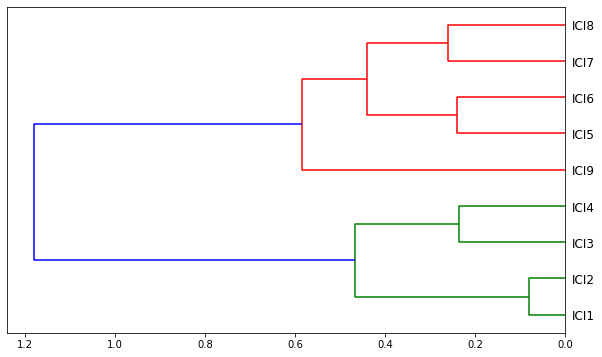

In [41]:
cluster_columns(X_train_clan)

We see that ICI1 tracks the duration of ICI2, ICI3 the duration of ICI4, and so on. It also seems that the last, very infrequent ICI9, seems more independent.

This reinforces the sequential structure of a coda - the duration of an ICI is overall most closely related to the duration of the surrounding ICIs.

### Partial dependence

Let's go back to querying our model and construct partial dependence plots. This is a technique that allows us to answer the following question: if the only thing that varied was a given column, say ICI4, how would that affect the prediction?

From the above considerations we know that ICI4 plays a key role in discerning between the clans. But what values of the ICI4 are most associated with each clan? Let's find out.

In [42]:
from sklearn.inspection import plot_partial_dependence

In [43]:
m.classes_

array(['EC1', 'EC2'], dtype=object)

Text(0.5, 0.98, 'Partial dependence plots for EC2')

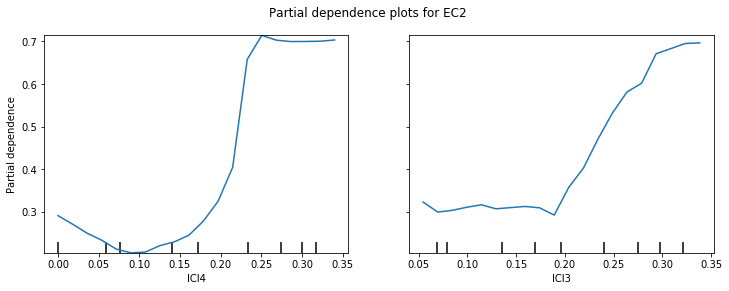

In [49]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(
    m,
    X_valid_clan,
    ['ICI4', 'ICI3'],
    grid_resolution=20,
    target=['EC1', 'EC2'],
    ax=ax);

plt.gcf().suptitle('Partial dependence plots for EC2')

We can see that there is a sharp jump roughly around 0.20 for ICI4. Once it crosses this threshold it immediately becomes a very strong indication that the coda orignated from a whale belonging to the EC2 clan.

With ICI3 the shift is more gradual - shorter intervals are associated with belonging to the EC1 clan and and association with the EC2 clan becomes linearly more probably as the interval grows past the 0.20 mark.

### Understanding predictions on single example

As we explore our data, we might be interested in understanding why our model made this specific prediction on a given row or data.

To this effect, we can use this very handy waterfall chart.

In [54]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [93]:
prediction,bias,contributions = treeinterpreter.predict(m, X_valid_clan.iloc[100].values.reshape(1,-1))

Our model is convinced the whale belongs to the EC1 clan.

In [94]:
y_valid_clan.iloc[100]

'EC1'

And it is right! Let's see how it arrived at this prediction.

In [95]:
X_valid_clan.columns

Index(['ICI1', 'ICI2', 'ICI3', 'ICI4', 'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9'], dtype='object')

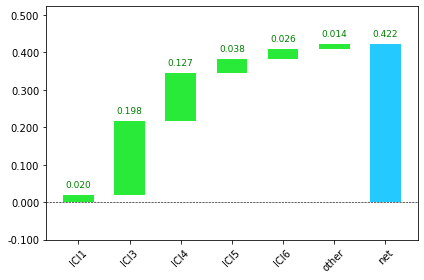

In [96]:
# code take from https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

waterfall(X_valid_clan.columns, contributions[0][:, 0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

For this particular example the durations of the listed ICIs all suggest, according to the model, that the whale belongs to the EC1. We can also see that the ICI3 was particularly indicative.

This is an unparalleled level of information that our model provides and does so with relative ease. It's performance falls slightly short of the performance of the RNN reported in the paper, nonetheless it facilitates carrying out a very detailed analysis of our data. It also doesn't require specialized hardware and allows a person carrying out the inquiry to arrive at the results much quicker than should they have to piece together training an RNN (even with a tool facilitating rapid prototyping like thie `fastai` library)